In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import assessment 
import calibration 
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
!pip uninstall mapie -y
!pip install git+https://github.com/scikit-learn-contrib/MAPIE@133-enhancement-top-label-calibration

Found existing installation: MAPIE 0.5.0
Uninstalling MAPIE-0.5.0:
  Successfully uninstalled MAPIE-0.5.0
  Cloning https://github.com/scikit-learn-contrib/MAPIE (to revision 133-enhancement-top-label-calibration) to /private/var/folders/md/d1_1xv0n0xv10pzzp76cl7kh0000gn/T/pip-req-build-5j9_tyhj
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/MAPIE /private/var/folders/md/d1_1xv0n0xv10pzzp76cl7kh0000gn/T/pip-req-build-5j9_tyhj
  Running command git checkout -b 133-enhancement-top-label-calibration --track origin/133-enhancement-top-label-calibration
  Switched to a new branch '133-enhancement-top-label-calibration'
  branch '133-enhancement-top-label-calibration' set up to track 'origin/133-enhancement-top-label-calibration'.
  Resolved https://github.com/scikit-learn-contrib/MAPIE to commit 7394b33e757865c57492590374b830fb16eb410a
  Preparing metadata (setup.py) ... done
  Created wheel for MAPIE: filename=MAPIE-0.5.0-py3-none-any.whl siz

In [3]:
from mapie.calibration import MapieCalibrator
from mapie.metrics import top_label_ece

### Set plotting aesthetics

In [4]:
mpl.rcParams.update({'font.size': 15})
mpl.rcParams.update({"axes.grid" : True, "grid.linestyle": '--', 
                     "grid.alpha": 0.8, "grid.color": "black"})
mpl.rcParams.update({"lines.linewidth" : 3})

# Load predictions from pretrained ResNet-50 model on CIFAR10

### Training data is not re-used; only validation data (called calibration data here), and test data is used

In [5]:
random_state = 20

X, y = make_classification(
    n_samples=20000,
    n_classes=2,
    n_informative=6,
    random_state=random_state
)

y += 1

X_, X_test, y_, y_test = train_test_split(
    X, y, test_size=0.33, random_state=random_state
)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_, y_, test_size=0.33, random_state=random_state
)

In [6]:
# reg_ = LogisticRegression(multi_class="multinomial")
# reg_.fit(X_train, y_train)

reg_ = RandomForestClassifier()
reg_.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
# Computing values for later usage
preds_calib = reg_.predict_proba(X_calib)
preds_test = reg_.predict_proba(X_test)
arg_max_preds_test = reg_.classes_[np.argmax(preds_test, axis=1)]

In [8]:
# Evaluating model
y_pred = reg_.predict(X_test)
accuracy_score(y_test, y_pred)

0.9240909090909091

# Recalibrate using histogram binning

In [9]:
points_per_bin=50

# initialize recalibrator and set number of points per bins
hb = calibration.HB_toplabel(points_per_bin=points_per_bin)
hb.fit(preds_calib, y_calib)

# get histogram binning probabilities on test data
preds_test_hb = hb.predict_proba(preds_test)

# MAPIE

In [10]:
mapie_reg = MapieCalibrator(estimator=reg_, cv="prefit")
mapie_reg.fit(X_calib, y_calib)
mapie_prob_preds = mapie_reg.predict_proba(X_test)
mapie_preds = mapie_reg.predict(X_test)

np.testing.assert_array_equal(mapie_preds, reg_.classes_[np.argmax(mapie_prob_preds, axis=1)])
np.testing.assert_array_equal(mapie_preds, arg_max_preds_test)


# Assess models using top-label {reliability diagram, ECE}

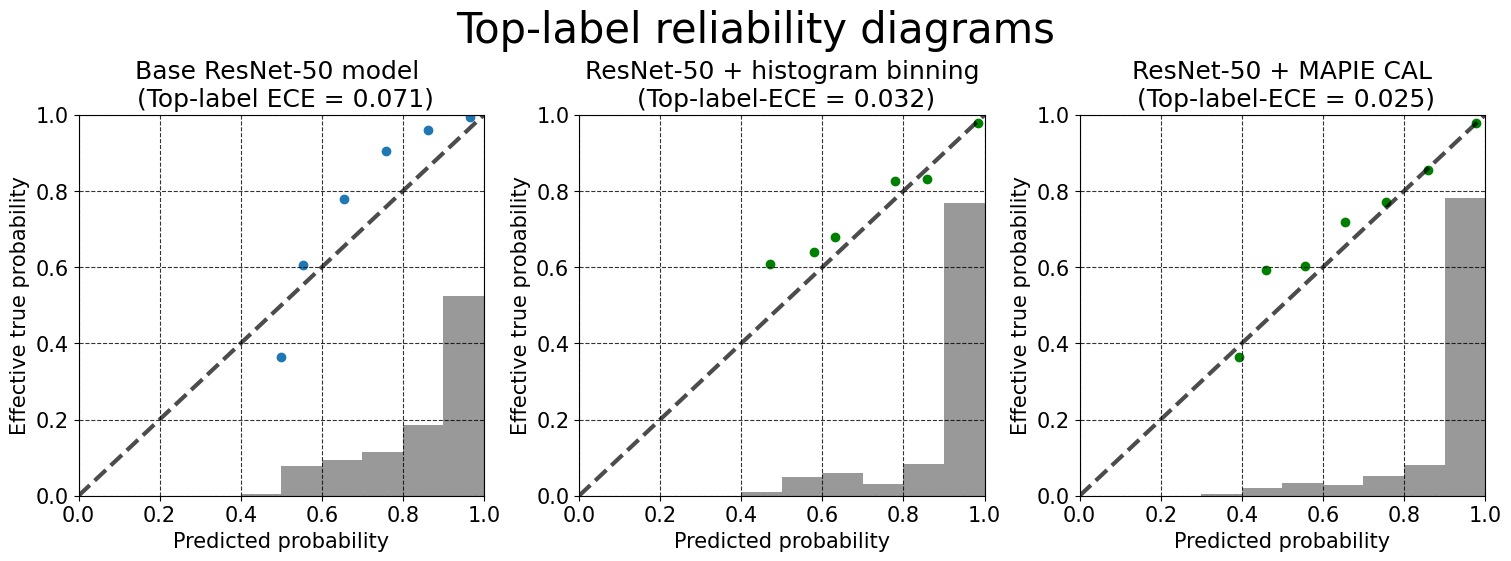

In [11]:
# make some plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5.5), constrained_layout=True)
fig.suptitle('Top-label reliability diagrams', fontsize=30)

assessment.toplabel_reliability_diagram(y_test, preds_test, ax=ax[0])
ax[0].set_title("Base ResNet-50 model \n (Top-label ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, preds_test)))

assessment.toplabel_reliability_diagram(y_test, preds_test_hb, arg_max_preds_test, ax=ax[1], color='g')
ax[1].set_title("ResNet-50 + histogram binning\n (Top-label-ECE = {:.3f})".format(
                                assessment.toplabel_ece(y_test, preds_test_hb, arg_max_preds_test)));

assessment.toplabel_reliability_diagram(y_test, np.max(mapie_prob_preds, axis=1), arg_max_preds_test, ax=ax[2], color='g')
ax[2].set_title("ResNet-50 + MAPIE CAL\n (Top-label-ECE = {:.3f})".format(assessment.toplabel_ece(y_test, np.max(mapie_prob_preds, axis=1), arg_max_preds_test)));

In [12]:
print("ECE on uncalibrated data:")
top_label_ece_their_uncalib = assessment.toplabel_ece(y_test, np.max(preds_test, axis=1), arg_max_preds_test)
top_label_ece_our_uncalib = top_label_ece(y_test, np.max(preds_test, axis=1), arg_max_preds_test)
print("THEIRS: ", top_label_ece_their_uncalib, " AND MAPIE: ", top_label_ece_our_uncalib)

print("ECE on HB calibrated data:")
top_label_ece_their_calib_hb = assessment.toplabel_ece(y_test, preds_test_hb, arg_max_preds_test)
top_label_ece_our_calib_hb = top_label_ece(y_test, preds_test_hb, arg_max_preds_test)
print("THEIRS: ", top_label_ece_their_calib_hb, " AND MAPIE: ", top_label_ece_our_calib_hb)

print("ECE on MAPIE calibrated data:")
top_label_ece_their_calib_mapie = assessment.toplabel_ece(y_test, np.max(mapie_prob_preds, axis=1), arg_max_preds_test)
top_label_ece_our_calib_mapie = top_label_ece(y_test, np.max(mapie_prob_preds, axis=1), arg_max_preds_test)
print("THEIRS: ", top_label_ece_their_calib_mapie, " AND MAPIE: ", top_label_ece_our_calib_mapie)


print("DIFF. between calibrated and uncalibrated:")
print("Diff. between uncalib and calib with HB, THEIR: ", top_label_ece_their_calib_hb-top_label_ece_their_uncalib, " OUR: ", top_label_ece_our_calib_hb-top_label_ece_our_uncalib)

print("DIFF. between calibrated and uncalibrated:")
print("Diff. between uncalib and calib with MAPIE, THEIR: ", top_label_ece_their_calib_mapie-top_label_ece_their_uncalib, " OUR: ", top_label_ece_our_calib_mapie-top_label_ece_our_uncalib)

ECE on uncalibrated data:
THEIRS:  0.07107424242424243  AND MAPIE:  0.06862148164150564
ECE on HB calibrated data:
THEIRS:  0.03200659537689066  AND MAPIE:  0.02417821861154215
ECE on MAPIE calibrated data:
THEIRS:  0.02461122158708729  AND MAPIE:  0.018812349838967922
DIFF. between calibrated and uncalibrated:
Diff. between uncalib and calib with HB, THEIR:  -0.039067647047351765  OUR:  -0.04444326302996349
DIFF. between calibrated and uncalibrated:
Diff. between uncalib and calib with MAPIE, THEIR:  -0.04646302083715514  OUR:  -0.049809131802537716
